In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import absolute
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Training Data

train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Testing Data

test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# Saving ID on a new variable and Dropping ID column

train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [5]:
# # Plotting to find outliers
# for items in train.columns:
#     if len(train[items].unique()) < 20:
#         sns.catplot(x=train[items], y=train['SalePrice'], data=train)
#         plt.show()
#     else:
#         sns.scatterplot(x=train[items],y=train['SalePrice'])
#         plt.show()


In [6]:
# Removing Outlier
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
print(train.shape)

(1458, 80)


Visualizing output data from train set

<AxesSubplot:>

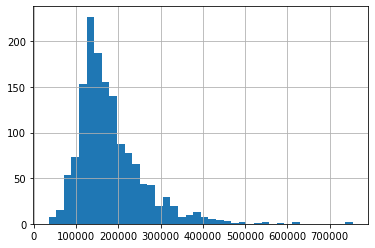

In [7]:
# Plotting output data for Visualization
train['SalePrice'].hist(bins = 40)

Data is skewed, we will use log1p to remove the skewness in data

<AxesSubplot:>

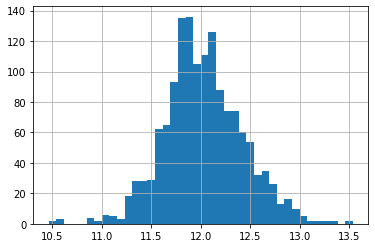

In [8]:
# Adjusting for Skewness
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train['SalePrice'].reset_index(drop=True)

train['SalePrice'].hist(bins = 40)

In [9]:
# Concat Testing part of both Train and Test and split SalePrice from Train data for Training
train_data = train.drop(['SalePrice'], axis=1)
total_data = pd.concat([train_data, test]).reset_index(drop=True)

In [10]:
# Total data is full data to be used for EDA
total_data.shape

(2917, 79)

In [11]:
print('columns containing missing values =',total_data.isnull().any().sum())

columns containing missing values = 34


                 0
PoolQC        2908
MiscFeature   2812
Alley         2719
Fence         2346
FireplaceQu   1420
LotFrontage    486
GarageCond     159
GarageQual     159
GarageYrBlt    159
GarageFinish   159
GarageType     157
BsmtCond        82
BsmtExposure    82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
MasVnrType      24
MasVnrArea      23
MSZoning         4
BsmtHalfBath     2
Utilities        2
Functional       2
BsmtFullBath     2
BsmtFinSF2       1
BsmtFinSF1       1
Exterior2nd      1
BsmtUnfSF        1
TotalBsmtSF      1
Exterior1st      1
SaleType         1
Electrical       1
KitchenQual      1
GarageArea       1
GarageCars       1


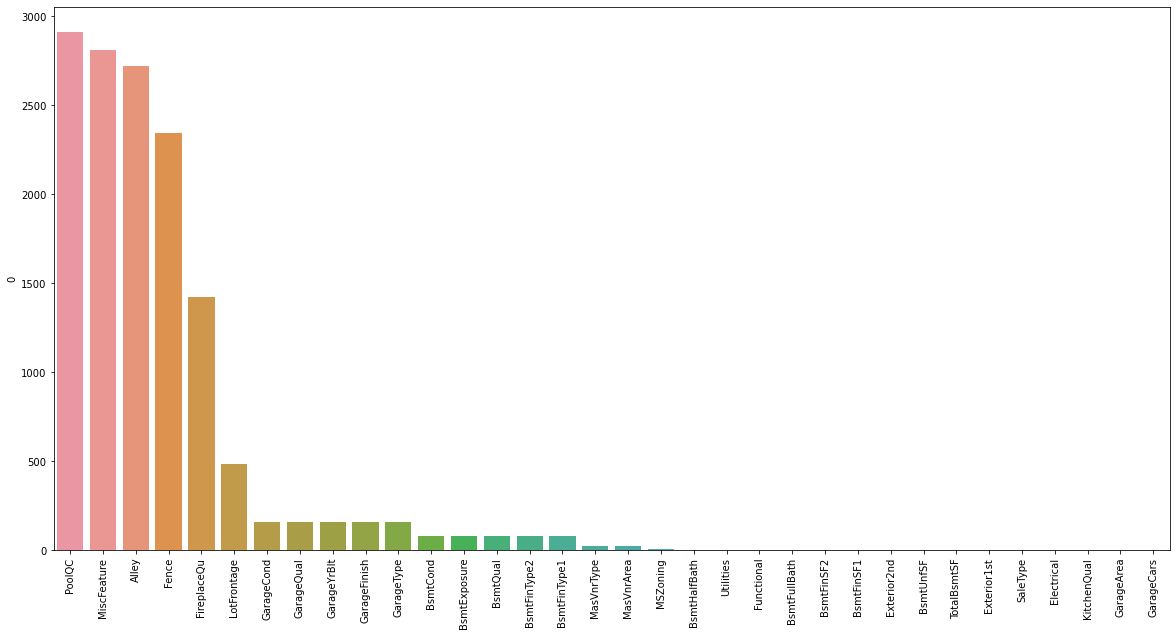

In [12]:
# Finding missing values to plot a Graph
missing_counts = pd.DataFrame(total_data.isnull().sum().sort_values(ascending=False))
missing_columns = missing_counts[missing_counts.iloc[:,0]>0]
# Plotting Missing Values
plt.figure(figsize=(20,10))
missing_columns = missing_counts[missing_counts.iloc[:,0]>0]
sns.barplot(x=missing_columns.index,y=missing_columns.iloc[:,0])
plt.xticks(rotation=90)
print(missing_columns)
plt.show()

In [13]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
total_data['MSSubClass'] = total_data['MSSubClass'].apply(str)
total_data['YrSold'] = total_data['YrSold'].astype(str)
total_data['MoSold'] = total_data['MoSold'].astype(str)

# Fixing columns : filling Null values with suitable values in columns
total_data['Functional'] = total_data['Functional'].fillna('Typ')
total_data['Electrical'] = total_data['Electrical'].fillna("SBrkr")
total_data['KitchenQual'] = total_data['KitchenQual'].fillna("TA")
total_data['Exterior1st'] = total_data['Exterior1st'].fillna(total_data['Exterior1st'].mode()[0])
total_data['Exterior2nd'] = total_data['Exterior2nd'].fillna(total_data['Exterior2nd'].mode()[0])
total_data['SaleType'] = total_data['SaleType'].fillna(total_data['SaleType'].mode()[0])
total_data["PoolQC"] = total_data["PoolQC"].fillna("None")

In [14]:
# Filling columns with Mode and Median values
total_data["LotFrontage"].fillna(total_data["LotFrontage"].median(),inplace=True)
total_data["MSZoning"].fillna(total_data["MSZoning"].mode(),inplace=True)

In [15]:
# Filling some columns Nan values with 0's

for item in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    total_data[item] = total_data[item].fillna(0)

# Filling categorial columns Nan Values with 'None'

for item in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    total_data[item] = total_data[item].fillna('None')

In [16]:
# Filling remaining Object type columns Nan values with None
objects = []
for i in total_data.columns:
    if total_data[i].dtype == object:
        objects.append(i)
total_data.update(total_data[objects].fillna('None'))

In [17]:
# Filling remaining Numerical type columns with 0 values
numerical = total_data.select_dtypes(include=np.number).columns.tolist()
for i in numerical:
    total_data.update(total_data[i].fillna(0))

Data Engineering 

In [18]:
# Dropping unwanted columns
total_data = total_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [19]:
# Engineered new columns 
total_data['YrBltAndRemod']=total_data['YearBuilt']+total_data['YearRemodAdd']
total_data['TotalSF']=total_data['TotalBsmtSF'] + total_data['1stFlrSF'] + total_data['2ndFlrSF']

total_data['Total_sqr_footage'] = (total_data['BsmtFinSF1'] + total_data['BsmtFinSF2'] +
                                 total_data['1stFlrSF'] + total_data['2ndFlrSF'])

total_data['Total_Bathrooms'] = (total_data['FullBath'] + (0.5 * total_data['HalfBath']) +
                               total_data['BsmtFullBath'] + (0.5 * total_data['BsmtHalfBath']))

total_data['Total_porch_sf'] = (total_data['OpenPorchSF'] + total_data['3SsnPorch'] +
                              total_data['EnclosedPorch'] + total_data['ScreenPorch'] +
                              total_data['WoodDeckSF'])

In [20]:
# Simplifying Features
total_data['haspool'] = total_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
total_data['has2ndfloor'] = total_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
total_data['hasgarage'] = total_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
total_data['hasbsmt'] = total_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
total_data['hasfireplace'] = total_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [21]:
# Adding pandas dummy values to encode features
print(total_data.shape)
final_data = pd.get_dummies(total_data).reset_index(drop=True)
print(final_data.shape)

(2917, 86)
(2917, 334)


In [22]:
# Splitting Train and test values now with help of variable 'y' 
x_train = final_data.iloc[:len(y_train), :]
x_test = final_data.iloc[len(x_train):, :]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)

x_train (1458, 334)
y_train (1458,)
x_test (1459, 334)


In [23]:
# We still have some data fields which are overfitting 
overfit = []
for i in x_train.columns:
    counts = x_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(x_train) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
# MSZoning_C have an extra field added in data 
overfit.append('MSZoning_C (all)')

X_train = x_train.drop(overfit, axis=1).copy()
X_test = x_test.drop(overfit, axis=1).copy()
Y_train = y_train.copy()

print('X_train', X_train.shape)
print('Y_train', Y_train.shape)
print('X_test', X_test.shape)

X_train (1458, 331)
Y_train (1458,)
X_test (1459, 331)


Implementing Model 

In [24]:
# Define Model
model = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42)

In [25]:
# define KFold
kfolds = KFold(n_splits=10, shuffle = True, random_state=42)

In [26]:
# evaluate model
# score = np.sqrt(-cross_val_score(model, X_train, Y_train,scoring="neg_mean_squared_error",cv=kfolds))
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# cross_val_score

In [27]:
# Training the Model 
# xgb = model.fit(X_train, Y_train)

In [28]:
# Predicting Test values
# submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
# submission.iloc[:,1] = (np.expm1(model.predict(X_test)))

In [29]:
# Fixing output range
# q1 = submission['SalePrice'].quantile(0.0042)
# q2 = submission['SalePrice'].quantile(0.99)
# # Quantiles helping us get some extreme values for extremely low or high values 
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
# submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [ ]:
# Output
# submission.head()